<a href="https://colab.research.google.com/github/sreesriavvaru123/MI/blob/main/MI_CNN_LSTM_v11_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab-compatible notebook for MI detection using PTB-XL with 12-leads and 10-fold CV



## STEP 1: Install necessary packages



In [ ]:
!pip install wfdb scikit-learn matplotlib tensorflow --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 127.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.


In [ ]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.4
    Uninstalling typeguard-4.4.4:
      Successfully uninstalled typeguard-4.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


## STEP 2: Import required libraries


In [ ]:
# CNN-LSTM with Stacking Decoding on PTB-XL (MI, Healthy, Other) - 12-lead Version
# Step 2: Imports
import os
import numpy as np
import pandas as pd
import wfdb
from tqdm import tqdm
from scipy.signal import savgol_filter, resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization, Dropout, LSTM, Dense
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.callbacks import EarlyStopping

## STEP 3: Download and unzip PTB-XL data

In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install kaggle CLI if not already
!pip install -q kaggle

# Download the PTB-XL dataset
!kaggle datasets download -d khyeh0719/ptb-xl-dataset

# Unzip the dataset
!unzip ptb-xl-dataset.zip -d ptb-xl


Streaming output truncated to the last 5000 lines.
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19338_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.dat  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.dat  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.dat  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/1934

## STEP 4: Load metadata and diagnostic class mapping

In [ ]:
import pandas as pd

ptbxl_path = "/content/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/"
print("Loading metadata...")

# Load metadata and SCP diagnostic info
df = pd.read_csv(ptbxl_path + 'ptbxl_database.csv')
class_map = pd.read_csv(ptbxl_path + 'scp_statements.csv', index_col=0)

# Add full path to 100Hz signal files
df['filename_lr'] = ptbxl_path + df['filename_lr']

# Evaluate stringified dict to real dict
df['scp_codes'] = df['scp_codes'].apply(eval)

# Define mapping from SCP codes to 3 classes
def map_3_classes(scp_codes, class_map):
    """
    Maps SCP codes to 3 classes: MI, NORM, OTHER.
    """
    mi_codes = class_map[class_map['diagnostic_class'] == 'MI'].index.tolist()
    norm_codes = class_map[class_map['diagnostic_class'] == 'NORM'].index.tolist()

    for code in scp_codes.keys():
        if code in mi_codes:
            return 'MI'
        if code in norm_codes:
            return 'NORM'

    # If no MI or NORM code is found, return 'OTHER'
    return 'OTHER'

# Apply 3-class mapping
df['class'] = df['scp_codes'].apply(lambda x: map_3_classes(x, class_map))

# Drop rows with unmapped class
df = df[df['class'].notnull()]

# Display class distribution
print("Class distribution:")
print(df['class'].value_counts())

# Final usable dataset
df_multiclass = df[['filename_lr', 'class']]

Loading metadata...
Class distribution:
class
NORM     9528
OTHER    6824
MI       5485
Name: count, dtype: int64


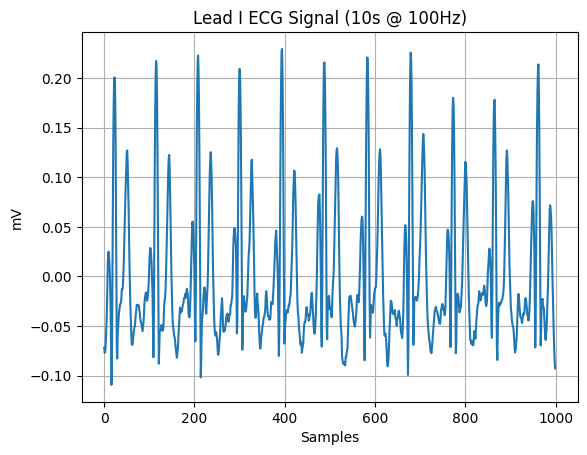

In [ ]:
# Step 4: Signal Processing Function

def preprocess_ecg(record_path):
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal.T  # Shape (12, 5000)

    # Denoising (per lead)
    signal_denoised = savgol_filter(signal, window_length=13, polyorder=3, axis=1)
    baseline = savgol_filter(signal_denoised, window_length=301, polyorder=4, axis=1)
    signal_clean = signal_denoised - baseline

    # Downsample from 500Hz to 250Hz
    # signal_downsampled = resample(signal_clean, 1000, axis=1)  # Direct to fixed 250Hz * 10s = 2500 samples
    return signal_clean

import matplotlib.pyplot as plt

test_ecg = preprocess_ecg(df_multiclass['filename_lr'].values[0].replace('.hea', ''))
plt.plot(test_ecg[0])  # Plot lead I
plt.title("Lead I ECG Signal (10s @ 100Hz)")
plt.xlabel("Samples")
plt.ylabel("mV")
plt.grid(True)
plt.show()

# Step 5: Create Dataset

def create_dataset(df, max_per_class=None):
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle
    X, y = [], []
    counts = {"MI": 0, "NORM": 0, "OTHER": 0}
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        label = row["class"]
        if max_per_class and counts[label] >= max_per_class:
            continue
        path = row["filename_lr"].replace(".hea", "")  # Remove .hea extension
        try:
            ecg = preprocess_ecg(path)
            if ecg.shape != (12, 1000):
                print(f"Skipping {path} due to incorrect shape {ecg.shape}")
                continue
            X.append(ecg)
            y.append(["MI", "NORM", "OTHER"].index(label))
            counts[label] += 1
        except Exception as e:
            print(f"Error processing {path}: {e}")
            continue
    print("Final class counts:", counts)
    X = np.array(X)
    y = to_categorical(y, num_classes=3)
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    return X, y


In [ ]:
# Unbalanced
print("Creating unbalanced dataset...")
X_unbal, y_unbal = create_dataset(df_multiclass)

# Balanced
print("Creating balanced dataset...")
X_bal, y_bal = create_dataset(df_multiclass, max_per_class=5000)

Creating unbalanced dataset...


100%|██████████| 21837/21837 [02:25<00:00, 149.94it/s]


Final class counts: {'MI': 5485, 'NORM': 9528, 'OTHER': 6824}
X shape: (21837, 12, 1000)
y shape: (21837, 3)
Creating balanced dataset...


100%|██████████| 21837/21837 [01:54<00:00, 189.96it/s] 


Final class counts: {'MI': 5000, 'NORM': 5000, 'OTHER': 5000}
X shape: (15000, 12, 1000)
y shape: (15000, 3)


In [ ]:
# First: Train+Val (80%) and Test (20%)
# Step 7: Split 60/20/20
X = np.transpose(X_bal, (0, 2, 1))
y = y_bal
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y.argmax(axis=1), random_state=42)

# Then: Train (60%) and Val (20%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp.argmax(axis=1), random_state=42)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)


Train shape: (9000, 1000, 12)
Validation shape: (3000, 1000, 12)
Test shape: (3000, 1000, 12)


In [ ]:
print(y_train)
y_train_3classes = df['class']
print(y_train_3classes)

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
0         NORM
1         NORM
2         NORM
3         NORM
4         NORM
         ...  
21832    OTHER
21833     NORM
21834    OTHER
21835     NORM
21836     NORM
Name: class, Length: 21837, dtype: object


In [ ]:
# === CNN-LSTM BINARY CLASSIFIER ===
def create_binary_model():
    input_layer = Input(shape=(1000, 12))  # 12-lead ECG, 1000 samples
    x = Conv1D(32, 5, activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.5)(x)

    x = Conv1D(32, 5, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.5)(x)

    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(64)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def get_meta_features(models, X):
    features = []
    for model in models:
        pred = model.predict(X, verbose=0)
        features.append(pred)
    return np.concatenate(features, axis=1)  # shape: (samples, 6)

# === META CLASSIFIER ===
def create_meta_model(num_classes=3):
    model = Sequential([
        Input(shape=(3,)),  # CHANGED from 6 to 3
        Dense(64, activation='tanh'),
        Dense(32, activation='tanh'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def prepare_binary_dataset(X, y, class_a, class_b):
    idx = np.where((y == class_a) | (y == class_b))[0]
    X_bin = X[idx]
    y_bin = y[idx]
    y_bin = np.where(y_bin == class_a, 0, 1)  # class_a → 0, class_b → 1
    y_bin = to_categorical(y_bin, 2)
    return X_bin, y_bin

def get_meta_features(models, X):
    # Use only P(class 1) from softmax output of each model
    features = [model.predict(X, verbose=0)[:, 1].reshape(-1, 1) for model in models]
    return np.concatenate(features, axis=1)  # shape: (samples, 3)

model = create_meta_model(num_classes=3)
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,435 (9.51 KB)

 Trainable params: 2,435 (9.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def prepare_binary_dataset(X, y_onehot, class_a, class_b):
    """
    Extracts a binary dataset from the full one-hot encoded dataset.

    Parameters:
        X: Input samples, shape (N, 1000, 12)
        y_onehot: One-hot labels, shape (N, 3)
        class_a, class_b: The two class indices to compare (e.g., 0 and 2)

    Returns:
        X_binary: Filtered inputs for the 2 classes
        y_binary: One-hot encoded binary labels (N, 2)
    """
    # Convert one-hot → class index (e.g., 0, 1, 2)
    y_class = np.argmax(y_onehot, axis=1)

    # Get only samples of class_a or class_b
    idx = np.where((y_class == class_a) | (y_class == class_b))[0]
    X_bin = X[idx]
    y_bin = y_class[idx]

    # Relabel: class_a → 0, class_b → 1
    y_bin = np.where(y_bin == class_a, 0, 1)

    # Convert to binary one-hot encoding
    y_bin = to_categorical(y_bin, 2)

    return X_bin, y_bin


In [22]:
from keras.callbacks import ModelCheckpoint

# === EARLY STOPPING CALLBACK ===
early_stop = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
)

# Binary 1: MI (0) vs OTHER (2)
print("Binary classification of class MI vs OTHER")
checkpoint = ModelCheckpoint(
    'best_model1.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
)
X1, y1 = prepare_binary_dataset(X_train, y_train, 0, 2)
model1 = create_binary_model()
model1.fit(X1, y1, epochs=50, batch_size=32, validation_split=0.2, callbacks=[checkpoint, early_stop], shuffle=True)

# Binary 2: NORM (1) vs OTHER (2)
print("Binary classification of class NORM vs OTHER")
checkpoint = ModelCheckpoint(
    'best_model2.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
)
X2, y2 = prepare_binary_dataset(X_train, y_train, 1, 2)
model2 = create_binary_model()
model2.fit(X2, y2, epochs=50, batch_size=32, validation_split=0.2, callbacks=[checkpoint, early_stop], shuffle=True)

# Binary 3: MI (0) vs NORM (1)
print("Binary classification of class MI vs NORM")
checkpoint = ModelCheckpoint(
    'best_model3.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
)
X3, y3 = prepare_binary_dataset(X_train, y_train, 0, 1)
model3 = create_binary_model()
model3.fit(X3, y3, epochs=50, batch_size=32, validation_split=0.2, callbacks=[checkpoint, early_stop], shuffle=True)


Binary classification of class MI vs OTHER
Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.5466 - loss: 0.6862
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_model1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 186ms/step - accuracy: 0.5468 - loss: 0.6861 - val_accuracy: 0.5000 - val_loss: 0.7791
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.6457 - loss: 0.6375
Epoch 2: val_accuracy improved from 0.50000 to 0.62250, saving model to best_model1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 196ms/step - accuracy: 0.6457 - loss: 0.6375 - val_accuracy: 0.6225 - val_loss: 0.6629
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.6675 - loss: 0.6206
Epoch 3: val_accuracy did not improve from 0.62250
150/150 ━━━━━━━━━━━━━━━━━━━━ 39s 186ms/step - accuracy: 0.6676 - loss: 0.6206 - val_accuracy: 0.5800 - val_loss: 0.6953
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.6754 - loss: 0.6070
Epoch 4: val_accuracy improved from 0.62250 to 0.64083, saving model to best_model1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 192ms/step - accuracy: 0.6755 - loss: 0.6070 - val_accuracy: 0.6408 - val_loss: 0.6284
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6892 - loss: 0.6010
Epoch 5: val_accuracy did not improve from 0.64083
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 184ms/step - accuracy: 0.6893 - loss: 0.6010 - val_accuracy: 0.6233 - val_loss: 0.6618
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.7041 - loss: 0.5842
Epoch 6: val_accuracy improved from 0.64083 to 0.68583, saving model to best_model1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 193ms/step - accuracy: 0.7040 - loss: 0.5842 - val_accuracy: 0.6858 - val_loss: 0.5917
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.7114 - loss: 0.5798
Epoch 7: val_accuracy improved from 0.68583 to 0.69833, saving model to best_model1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 197ms/step - accuracy: 0.7114 - loss: 0.5798 - val_accuracy: 0.6983 - val_loss: 0.5837
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.7065 - loss: 0.5808
Epoch 8: val_accuracy improved from 0.69833 to 0.70250, saving model to best_model1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 191ms/step - accuracy: 0.7065 - loss: 0.5808 - val_accuracy: 0.7025 - val_loss: 0.5630
Epoch 9/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.7249 - loss: 0.5566
Epoch 9: val_accuracy improved from 0.70250 to 0.70333, saving model to best_model1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 191ms/step - accuracy: 0.7248 - loss: 0.5566 - val_accuracy: 0.7033 - val_loss: 0.5755
Epoch 10/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.7263 - loss: 0.5553
Epoch 10: val_accuracy improved from 0.70333 to 0.71583, saving model to best_model1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 188ms/step - accuracy: 0.7263 - loss: 0.5553 - val_accuracy: 0.7158 - val_loss: 0.5854
Epoch 11/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.7329 - loss: 0.5496
Epoch 11: val_accuracy did not improve from 0.71583
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 187ms/step - accuracy: 0.7328 - loss: 0.5497 - val_accuracy: 0.7142 - val_loss: 0.5629
Epoch 12/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.7334 - loss: 0.5419
Epoch 12: val_accuracy did not improve from 0.71583
150/150 ━━━━━━━━━━━━━━━━━━━━ 30s 197ms/step - accuracy: 0.7333 - loss: 0.5420 - val_accuracy: 0.7158 - val_loss: 0.5583
Epoch 13/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.7436 - loss: 0.5489
Epoch 13: val_accuracy improved from 0.71583 to 0.72750, saving model to best_model1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 191ms/step - accuracy: 0.7436 - loss: 0.5488 - val_accuracy: 0.7275 - val_loss: 0.5773
Epoch 14/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.7383 - loss: 0.5464
Epoch 14: val_accuracy improved from 0.72750 to 0.72833, saving model to best_model1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 29s 194ms/step - accuracy: 0.7384 - loss: 0.5464 - val_accuracy: 0.7283 - val_loss: 0.5709
Epoch 15/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.7385 - loss: 0.5366
Epoch 15: val_accuracy improved from 0.72833 to 0.74167, saving model to best_model1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 186ms/step - accuracy: 0.7385 - loss: 0.5366 - val_accuracy: 0.7417 - val_loss: 0.5363
Epoch 16/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.7184 - loss: 0.5761
Epoch 16: val_accuracy did not improve from 0.74167
150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 190ms/step - accuracy: 0.7184 - loss: 0.5760 - val_accuracy: 0.7142 - val_loss: 0.5884
Epoch 17/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.7482 - loss: 0.5376
Epoch 17: val_accuracy did not improve from 0.74167
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 187ms/step - accuracy: 0.7481 - loss: 0.5377 - val_accuracy: 0.7308 - val_loss: 0.5798
Epoch 18/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.7350 - loss: 0.5369
Epoch 18: val_accuracy did not improve from 0.74167
150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 192ms/step - accuracy: 0.7350 - loss: 0.5370 - val_accuracy: 0.7308 - val_loss: 0.5462
Epoch 19/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.7449 - loss: 0.5371
Epoch 19

150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 193ms/step - accuracy: 0.7442 - loss: 0.5311 - val_accuracy: 0.7458 - val_loss: 0.5557
Epoch 25/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.7493 - loss: 0.5350
Epoch 25: val_accuracy did not improve from 0.74583
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 187ms/step - accuracy: 0.7493 - loss: 0.5350 - val_accuracy: 0.7300 - val_loss: 0.5541
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 15.
Binary classification of class NORM vs OTHER
Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.6994 - loss: 0.5720
Epoch 1: val_accuracy improved from -inf to 0.49500, saving model to best_model2.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 32s 192ms/step - accuracy: 0.6999 - loss: 0.5716 - val_accuracy: 0.4950 - val_loss: 1.6478
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.8101 - loss: 0.4509
Epoch 2: val_accuracy improved from 0.49500 to 0.54667, saving model to best_model2.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 29s 193ms/step - accuracy: 0.8102 - loss: 0.4508 - val_accuracy: 0.5467 - val_loss: 1.2280
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8348 - loss: 0.4032
Epoch 3: val_accuracy improved from 0.54667 to 0.69167, saving model to best_model2.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 39s 181ms/step - accuracy: 0.8347 - loss: 0.4032 - val_accuracy: 0.6917 - val_loss: 0.9275
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.8364 - loss: 0.4117
Epoch 4: val_accuracy improved from 0.69167 to 0.78417, saving model to best_model2.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 190ms/step - accuracy: 0.8364 - loss: 0.4117 - val_accuracy: 0.7842 - val_loss: 0.5569
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.8254 - loss: 0.3979
Epoch 5: val_accuracy improved from 0.78417 to 0.82167, saving model to best_model2.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 183ms/step - accuracy: 0.8253 - loss: 0.3979 - val_accuracy: 0.8217 - val_loss: 0.4079
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.8429 - loss: 0.3777
Epoch 6: val_accuracy did not improve from 0.82167
150/150 ━━━━━━━━━━━━━━━━━━━━ 29s 192ms/step - accuracy: 0.8429 - loss: 0.3777 - val_accuracy: 0.8100 - val_loss: 0.4331
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.8518 - loss: 0.3647
Epoch 7: val_accuracy improved from 0.82167 to 0.84167, saving model to best_model2.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 188ms/step - accuracy: 0.8518 - loss: 0.3648 - val_accuracy: 0.8417 - val_loss: 0.3638
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8616 - loss: 0.3536
Epoch 8: val_accuracy did not improve from 0.84167
150/150 ━━━━━━━━━━━━━━━━━━━━ 29s 190ms/step - accuracy: 0.8616 - loss: 0.3537 - val_accuracy: 0.8308 - val_loss: 0.3900
Epoch 9/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.8457 - loss: 0.3605
Epoch 9: val_accuracy did not improve from 0.84167
150/150 ━━━━━━━━━━━━━━━━━━━━ 43s 204ms/step - accuracy: 0.8457 - loss: 0.3605 - val_accuracy: 0.8358 - val_loss: 0.4031
Epoch 10/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.8567 - loss: 0.3522
Epoch 10: val_accuracy did not improve from 0.84167
150/150 ━━━━━━━━━━━━━━━━━━━━ 39s 188ms/step - accuracy: 0.8568 - loss: 0.3522 - val_accuracy: 0.8408 - val_loss: 0.3704
Epoch 11/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.8698 - loss: 0.3290
Epoch 11: va

150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 189ms/step - accuracy: 0.8597 - loss: 0.3600 - val_accuracy: 0.8633 - val_loss: 0.3661
Epoch 14/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8671 - loss: 0.3328
Epoch 14: val_accuracy did not improve from 0.86333
150/150 ━━━━━━━━━━━━━━━━━━━━ 29s 192ms/step - accuracy: 0.8670 - loss: 0.3328 - val_accuracy: 0.8400 - val_loss: 0.4440
Epoch 15/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8511 - loss: 0.3425
Epoch 15: val_accuracy did not improve from 0.86333
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 182ms/step - accuracy: 0.8511 - loss: 0.3424 - val_accuracy: 0.8317 - val_loss: 0.3871
Epoch 16/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8653 - loss: 0.3384
Epoch 16: val_accuracy did not improve from 0.86333
150/150 ━━━━━━━━━━━━━━━━━━━━ 29s 190ms/step - accuracy: 0.8653 - loss: 0.3384 - val_accuracy: 0.8475 - val_loss: 0.3647
Epoch 17/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8669 - loss: 0.3222
Epoch 17

150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 185ms/step - accuracy: 0.7564 - loss: 0.5078 - val_accuracy: 0.7983 - val_loss: 0.6317
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8306 - loss: 0.4175
Epoch 2: val_accuracy did not improve from 0.79833
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 186ms/step - accuracy: 0.8307 - loss: 0.4174 - val_accuracy: 0.6142 - val_loss: 0.5803
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8356 - loss: 0.3880
Epoch 3: val_accuracy did not improve from 0.79833
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 185ms/step - accuracy: 0.8356 - loss: 0.3879 - val_accuracy: 0.7817 - val_loss: 0.4683
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8464 - loss: 0.3774
Epoch 4: val_accuracy improved from 0.79833 to 0.83250, saving model to best_model3.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 186ms/step - accuracy: 0.8464 - loss: 0.3773 - val_accuracy: 0.8325 - val_loss: 0.3615
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8440 - loss: 0.3653
Epoch 5: val_accuracy improved from 0.83250 to 0.83750, saving model to best_model3.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 186ms/step - accuracy: 0.8440 - loss: 0.3653 - val_accuracy: 0.8375 - val_loss: 0.3765
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.8571 - loss: 0.3543
Epoch 6: val_accuracy improved from 0.83750 to 0.85417, saving model to best_model3.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 186ms/step - accuracy: 0.8571 - loss: 0.3543 - val_accuracy: 0.8542 - val_loss: 0.3387
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.8426 - loss: 0.3719
Epoch 7: val_accuracy did not improve from 0.85417
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 184ms/step - accuracy: 0.8426 - loss: 0.3718 - val_accuracy: 0.8417 - val_loss: 0.3666
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8656 - loss: 0.3303
Epoch 8: val_accuracy improved from 0.85417 to 0.86000, saving model to best_model3.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 181ms/step - accuracy: 0.8655 - loss: 0.3303 - val_accuracy: 0.8600 - val_loss: 0.3499
Epoch 9/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.8569 - loss: 0.3500
Epoch 9: val_accuracy improved from 0.86000 to 0.86250, saving model to best_model3.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 185ms/step - accuracy: 0.8570 - loss: 0.3499 - val_accuracy: 0.8625 - val_loss: 0.3398
Epoch 10/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8609 - loss: 0.3342
Epoch 10: val_accuracy did not improve from 0.86250
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 181ms/step - accuracy: 0.8609 - loss: 0.3342 - val_accuracy: 0.8550 - val_loss: 0.3320
Epoch 11/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.8723 - loss: 0.3242
Epoch 11: val_accuracy did not improve from 0.86250
150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 188ms/step - accuracy: 0.8723 - loss: 0.3242 - val_accuracy: 0.8442 - val_loss: 0.3602
Epoch 12/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8692 - loss: 0.3238
Epoch 12: val_accuracy did not improve from 0.86250
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 184ms/step - accuracy: 0.8692 - loss: 0.3239 - val_accuracy: 0.8583 - val_loss: 0.3451
Epoch 13/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8661 - loss: 0.3280
Epoch 13

150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 187ms/step - accuracy: 0.8801 - loss: 0.3215 - val_accuracy: 0.8667 - val_loss: 0.3281
Epoch 19/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8831 - loss: 0.2892
Epoch 19: val_accuracy did not improve from 0.86667
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 177ms/step - accuracy: 0.8831 - loss: 0.2893 - val_accuracy: 0.8633 - val_loss: 0.3227
Epoch 20/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8714 - loss: 0.3169
Epoch 20: val_accuracy did not improve from 0.86667
150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 181ms/step - accuracy: 0.8714 - loss: 0.3169 - val_accuracy: 0.8517 - val_loss: 0.3513
Epoch 21/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8785 - loss: 0.3050
Epoch 21: val_accuracy did not improve from 0.86667
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 183ms/step - accuracy: 0.8785 - loss: 0.3050 - val_accuracy: 0.8575 - val_loss: 0.3348
Epoch 22/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8794 - loss: 0.2991
Epoch 22

150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 183ms/step - accuracy: 0.8976 - loss: 0.2750 - val_accuracy: 0.8683 - val_loss: 0.3247
Epoch 25/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8909 - loss: 0.2929
Epoch 25: val_accuracy did not improve from 0.86833
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 183ms/step - accuracy: 0.8909 - loss: 0.2928 - val_accuracy: 0.8617 - val_loss: 0.3439
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 15.


In [23]:
# 7. Train Meta-Classifier on Full 3-Class Data
model1.load_weights('best_model1.h5')
model2.load_weights('best_model2.h5')
model3.load_weights('best_model3.h5')


X_meta_train = get_meta_features([model1, model2, model3], X_train)
meta_model = create_meta_model(num_classes=3)
history = meta_model.fit(X_meta_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6951 - loss: 0.7521 - val_accuracy: 0.7178 - val_loss: 0.6835
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7350 - loss: 0.6299 - val_accuracy: 0.7222 - val_loss: 0.6864
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7476 - loss: 0.6132 - val_accuracy: 0.7211 - val_loss: 0.6924
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7440 - loss: 0.6130 - val_accuracy: 0.7222 - val_loss: 0.6773
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7443 - loss: 0.6209 - val_accuracy: 0.7239 - val_loss: 0.6880
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7505 - loss: 0.6082 - val_accuracy: 0.7217 - val_loss: 0.6803
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7373 - loss: 0.6323 - val_accuracy: 0.7250 - val_loss: 0.6793
Epoch 8/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7407 - loss: 0.6143 - val_accuracy: 0.

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
Test Accuracy: 0.722
              precision    recall  f1-score   support

          MI       0.70      0.70      0.70      1000
        NORM       0.76      0.87      0.81      1000
       OTHER       0.69      0.59      0.64      1000

    accuracy                           0.72      3000
   macro avg       0.72      0.72      0.72      3000
weighted avg       0.72      0.72      0.72      3000



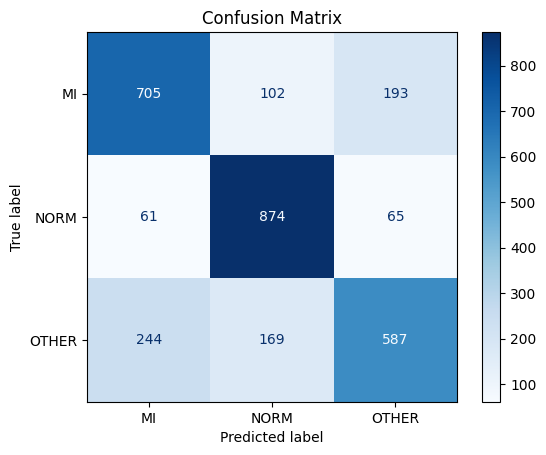

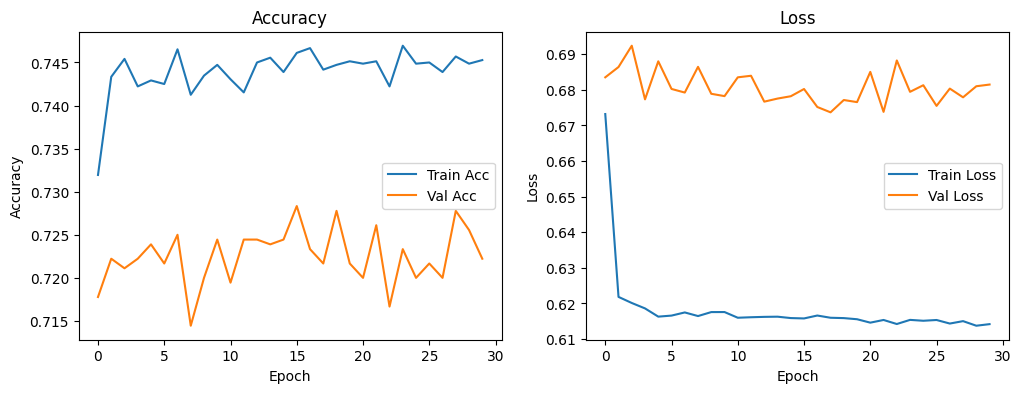

In [25]:
from sklearn.metrics import accuracy_score, classification_report
# Get predictions
X_meta_test = get_meta_features([model1, model2, model3], X_test)
y_pred = np.argmax(meta_model.predict(X_meta_test), axis=1)

from sklearn.metrics import classification_report, accuracy_score

# Convert one-hot to integer labels
y_test_labels = np.argmax(y_test, axis=1)

print("Test Accuracy:", accuracy_score(y_test_labels, y_pred))
print(classification_report(y_test_labels, y_pred, target_names=["MI", "NORM", "OTHER"]))

# Step 12: Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["MI", "NORM", "OTHER"]).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Step 13: Training Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Step 11: Classification Report
pred = model.predict(X_test)
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["MI", "NORM", "OTHER"]))

# Step 12: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["MI", "NORM", "OTHER"]).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Step 13: Training Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
